#This code takes a CSV file, analyzes the data, and automatically generates a PDF with insights using OpenAI.

In [ ]:
!pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 874.5 kB/s eta 0:00:00


In [ ]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40702 sha256=4e7a4c2698b42b0844be766a2fd095e37b3d9ee30fb7e7f54b4a884bfd2b135f
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [ ]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import io
from google.colab import userdata
from fpdf import FPDF

In [ ]:
# Configurar API da OpenAI
openai.api_key = userdata.get('OPENAI_API_KEY')

In [ ]:
#Fazer upload dos arquivos
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Automated Insights & Gen AI Manager - Challenge Data.csv to Automated Insights & Gen AI Manager - Challenge Data.csv
User uploaded file "Automated Insights & Gen AI Manager - Challenge Data.csv" with length 4246260 bytes


In [ ]:
data = pd.read_csv("Automated Insights & Gen AI Manager - Challenge Data.csv", sep=',')
filtered_data = data[data['status'].isin(['Won', 'Lost', 'Client Withdrew', 'Accenture Withdrew'])]

# Visualizando as primeiras linhas
filtered_data.head()

,dateid,Status Date,opp_id,status,win_rate_flag,Master_Client_Number,Client_Name,Market,MarketUnit,mu_group,...,QARecommendation,QAOverallAssesment,RiskClassificationDesc,CCIClassificationDesc,OMRiskProfileDesc,DaysinPipeline,SCDeviation,SCCalculatorEstimatedPct,SCCalculatorSuggestedPct,PrimaryWorkLocationDesc
670,20180906,8/31/2018 0:00,1864,Accenture Withdrew,N,1.230000e+09,ZVIBHH,North America,AREA1,NaN,...,NaN,NaN,NaN,NaN,NORMAL,NaN,NaN,NaN,NaN,USA
671,20180906,8/31/2018 0:00,3580,Client Withdrew,N,1.230000e+09,ZVIBHH,North America,AREA1,NaN,...,NaN,NaN,NaN,NaN,NORMAL,NaN,NaN,NaN,Required - Not Done,NaN
676,20180906,8/31/2018 0:00,3499,Accenture Withdrew,N,1.230000e+09,YXQJLR,North America,AREA2,NaN,...,NaN,NaN,NaN,NaN,NORMAL,NaN,NaN,NaN,NaN,India
677,20180906,8/31/2018 0:00,3707,Accenture Withdrew,N,1.230000e+09,OKQFUQ,North America,AREA2,NaN,...,NaN,NaN,NaN,NaN,NORMAL,NaN,NaN,NaN,NaN,NaN
678,20180906,8/31/2018 0:00,4477,Accenture Withdrew,N,1.230000e+09,PMSGAW,North America,AREA2,NaN,...,NaN,NaN,NaN,Alpha,NORMAL,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 1. Exploração Inicial dos Dados
print(filtered_data.info())
print(filtered_data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 1160 entries, 670 to 7184
Data columns (total 88 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dateid                      1160 non-null   int64  
 1   Status Date                 1160 non-null   object 
 2   opp_id                      1160 non-null   int64  
 3   status                      1160 non-null   object 
 4   win_rate_flag               1160 non-null   object 
 5   Master_Client_Number        1155 non-null   float64
 6   Client_Name                 1160 non-null   object 
 7   Market                      1160 non-null   object 
 8   MarketUnit                  1160 non-null   object 
 9   mu_group                    0 non-null      float64
 10  country                     1115 non-null   object 
 11  industry_group              1160 non-null   object 
 12  stage                       1160 non-null   object 
 13  probability                 1129 non

In [ ]:
filtered_data.count()

dateid                      1160
Status Date                 1160
opp_id                      1160
status                      1160
win_rate_flag               1160
                            ... 
DaysinPipeline               894
SCDeviation                   20
SCCalculatorEstimatedPct      20
SCCalculatorSuggestedPct     191
PrimaryWorkLocationDesc     1023
Length: 88, dtype: int64

In [ ]:
# Verificar valores ausentes

missing_values = filtered_data.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

Missing values:
 Master_Client_Number             5
mu_group                      1160
country                         45
probability                     31
PipelineEntryDt                266
extension                      154
Fiscal Period 2                277
OG Short                      1160
Pipeline Quarter              1160
PipelineClosePeriodQ          1160
StageUpdateDt                  255
OutsourcingCurrentDuration      92
OS Start                        92
CONS Start                    1004
OPP Start                       77
PLAN Date                      149
TRANSITION Start               712
TRANSFORMATION Start          1085
RUN Start                      544
CapitalInd                    1160
RiskTier                      1100
QARecommendation              1131
QAOverallAssesment            1131
RiskClassificationDesc        1112
CCIClassificationDesc         1102
DaysinPipeline                 266
SCDeviation                   1140
SCCalculatorEstimatedPct      1140
SCC

In [ ]:
# 2. Análise Descritiva
# Estatísticas descritivas
descriptive_stats = filtered_data['rev'].describe()
print("Descriptive Statistics:\n", descriptive_stats)

Descriptive Statistics:
 count      1160.000000
mean       3876.499351
std       13021.756554
min         -95.677000
25%          51.850000
50%         300.000000
75%        1950.340250
max      232450.052000
Name: rev, dtype: float64


In [ ]:
#Isolating the variables
won = filtered_data[filtered_data['status'] == 'Won'].groupby(["fiscal_year", "fiscal_quarter"]).agg({'rev': 'sum'}).reset_index()
lost = filtered_data[filtered_data['status'] == 'Lost'].groupby(["fiscal_year", "fiscal_quarter"]).agg({'rev': 'sum'}).reset_index()
cw = filtered_data[filtered_data['status'] == 'Client Withdrew'].groupby(["fiscal_year", "fiscal_quarter"]).agg({'rev': 'sum'}).reset_index()
aw = filtered_data[filtered_data['status'] == 'Accenture Withdrew'].groupby(["fiscal_year", "fiscal_quarter"]).agg({'rev': 'sum'}).reset_index()

In [ ]:
# Rename revenue columns to easily identify
won.rename(columns={'rev': 'won_rev'}, inplace=True)
lost.rename(columns={'rev': 'lost_rev'}, inplace=True)
cw.rename(columns={'rev': 'cw_rev'}, inplace=True)
aw.rename(columns={'rev': 'aw_rev'}, inplace=True)

# Merge DataFrames based on 'fiscal_year' and 'fiscal_quarter'
merged = pd.merge(won, lost, on=["fiscal_year", "fiscal_quarter"], how="outer")
merged = pd.merge(merged, cw, on=["fiscal_year", "fiscal_quarter"], how="outer")
merged = pd.merge(merged, aw, on=["fiscal_year", "fiscal_quarter"], how="outer")

# Replace NaN with 0 as missing data in a specific quarter means 0 revenue in that category
merged.fillna(0, inplace=True)

# Calculate 'Pursuit$'
merged['pursuit_rev'] = merged['won_rev'] + merged['lost_rev'] + merged['cw_rev'] + merged['aw_rev']

# Calculate 'Win Rate'
merged['win_rate'] = merged['won_rev'] / merged['pursuit_rev']

# View the result
display(merged)

,fiscal_year,fiscal_quarter,won_rev,lost_rev,cw_rev,aw_rev,pursuit_rev,win_rate
0,2018,1,104833.23572,295233.637,331283.96931,430244.242,1.161595e+06,0.090249
1,2018,2,175530.58828,85881.226,311587.92100,259882.494,8.328822e+05,0.210751
2,2018,3,114242.49874,98907.773,511492.65275,123035.873,8.476788e+05,0.134771
3,2018,4,168524.12187,259540.467,517215.42000,709303.127,1.654583e+06,0.101853


<Figure size 1000x600 with 0 Axes>

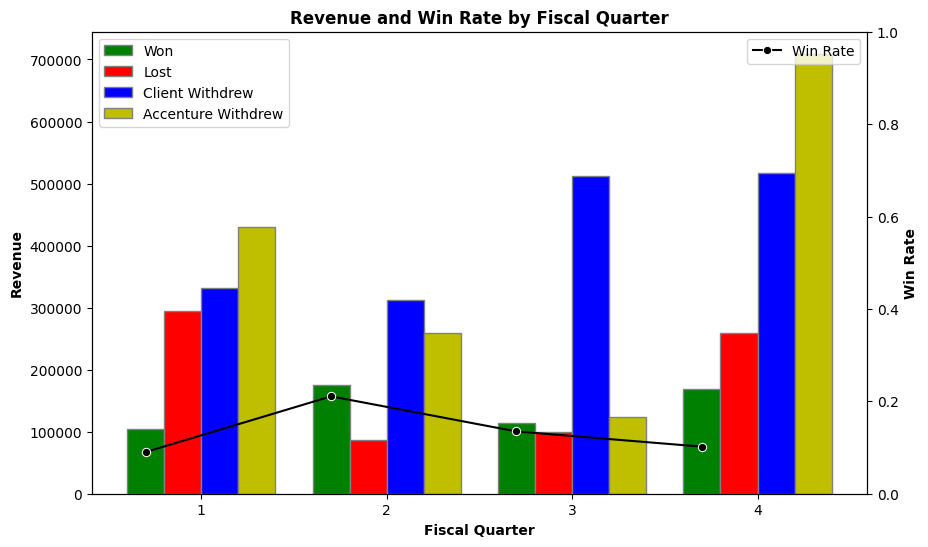

In [ ]:
plt.figure(figsize=(10, 6))
bar_width = 0.2
quarters = merged['fiscal_quarter'].astype(str)

# Definir a posição das barras no eixo x
r1 = range(len(merged))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de Barras
ax1.bar(r1, merged['won_rev'], color='g', width=bar_width, edgecolor='grey', label='Won')
ax1.bar(r2, merged['lost_rev'], color='r', width=bar_width, edgecolor='grey', label='Lost')
ax1.bar(r3, merged['cw_rev'], color='b', width=bar_width, edgecolor='grey', label='Client Withdrew')
ax1.bar(r4, merged['aw_rev'], color='y', width=bar_width, edgecolor='grey', label='Accenture Withdrew')

ax1.set_xlabel('Fiscal Quarter', fontweight='bold')
ax1.set_ylabel('Revenue', fontweight='bold')
ax1.set_title('Revenue and Win Rate by Fiscal Quarter', fontweight='bold')
ax1.set_xticks([r + 1.5 * bar_width for r in range(len(merged))])
ax1.set_xticklabels(quarters)
ax1.legend(loc='upper left')

# Gráfico de Linhas
ax2 = ax1.twinx()
sns.lineplot(data=merged, x=r1, y='win_rate', marker='o', color='black', label='Win Rate', ax=ax2)
ax2.set_ylabel('Win Rate', fontweight='bold')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

plt.show()

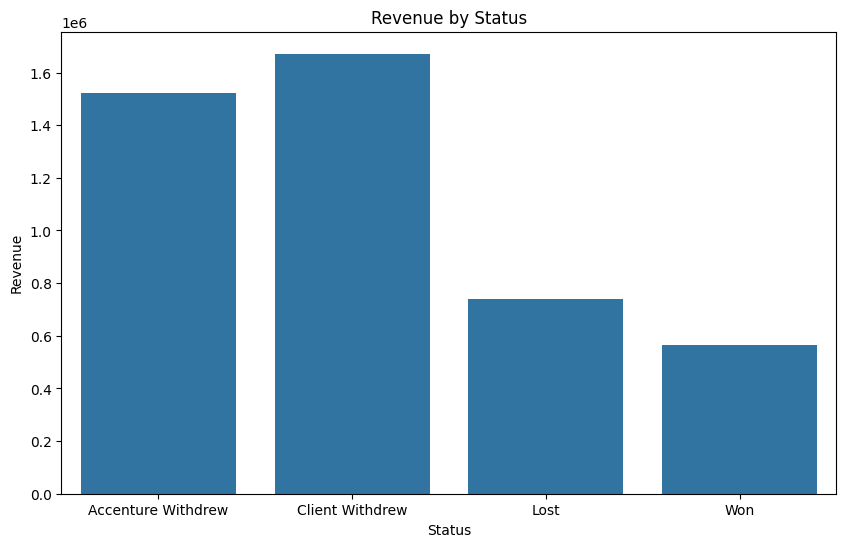

In [ ]:
# Relação entre variáveis categóricas e numéricas
revenue_by_status = filtered_data.groupby('status').agg({'rev': 'sum'}).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=revenue_by_status, x='status', y='rev')
plt.title('Revenue by Status')
plt.xlabel('Status')
plt.ylabel('Revenue')
plt.show()

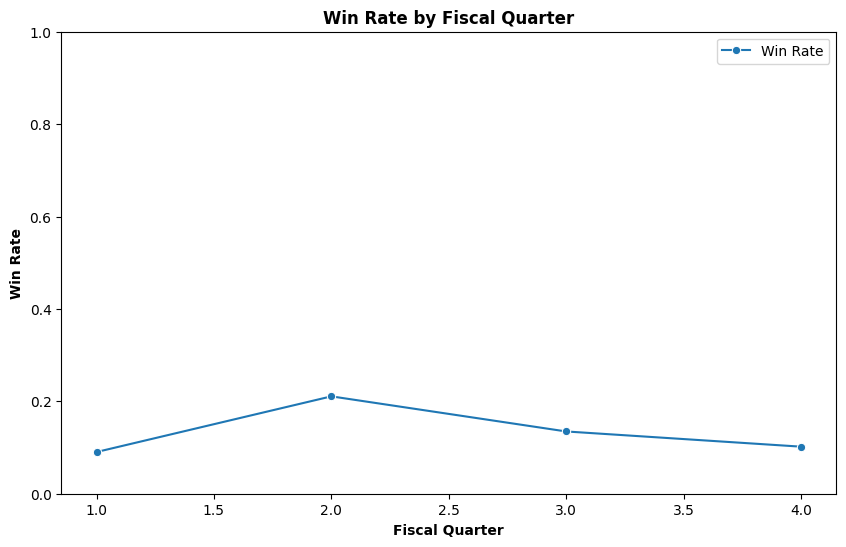

In [ ]:
# Gráfico de Linhas para Win Rate por Fiscal Quarter
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged, x='fiscal_quarter', y='win_rate', marker='o', label='Win Rate')
plt.xlabel('Fiscal Quarter', fontweight='bold')
plt.ylabel('Win Rate', fontweight='bold')
plt.title('Win Rate by Fiscal Quarter', fontweight='bold')
plt.ylim(0, 1)
plt.show()

In [ ]:
# Função para obter insights a partir da descrição do gráfico
def get_insights_from_description(description, context):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo", #gpt-4
        messages=[
            {"role": "system", "content": context},
            {"role": "user", "content": description}
        ],
        max_tokens=500
    )
    return response.choices[0].message['content'].strip()

In [ ]:
# Function to generate and save graphs, and obtain insights
def generate_graph_and_insights(data, col, colors, context):
    plt.figure(figsize=(14, 8))
    group_data = data.groupby([col, 'status'])['rev'].sum().unstack(fill_value=0).reset_index()
    group_data.set_index(col).plot(kind='bar', stacked=True, figsize=(14, 8), color=[colors.get(x) for x in group_data.columns[1:]])
    plt.title(f'Count by Status for {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Revenue')
    plt.legend(title='Status')
    plt.grid(False)

    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)

    # Sending information from charts to insights to provide information to the model
    description = f"This stacked bar chart shows the count of {col} by status. Here is the grouped data:\n"
    for index, row in group_data.iterrows():
        description += f"{index}: {', '.join([f'{status}: {int(value) if isinstance(value, (int, float)) else value}' for status, value in row.items()])}\n"

    insights = get_insights_from_description(description, context)

    return buf, insights

In [ ]:
# Função para gerar gráficos de introdução
def generate_intro_graphs(context):
    plt.figure(figsize=(10, 6))
    bar_width = 0.2
    quarters = merged['fiscal_quarter'].astype(str)

    # Definir a posição das barras no eixo x
    r1 = range(len(merged))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Gráfico de Barras
    ax1.bar(r1, merged['won_rev'], color='g', width=bar_width, edgecolor='grey', label='Won')
    ax1.bar(r2, merged['lost_rev'], color='r', width=bar_width, edgecolor='grey', label='Lost')
    ax1.bar(r3, merged['cw_rev'], color='b', width=bar_width, edgecolor='grey', label='Client Withdrew')
    ax1.bar(r4, merged['aw_rev'], color='y', width=bar_width, edgecolor='grey', label='Accenture Withdrew')

    ax1.set_xlabel('Fiscal Quarter', fontweight='bold')
    ax1.set_ylabel('Revenue', fontweight='bold')
    ax1.set_title('Revenue and Win Rate by Fiscal Quarter', fontweight='bold')
    ax1.set_xticks([r + 1.5 * bar_width for r in range(len(merged))])
    ax1.set_xticklabels(quarters)
    ax1.legend(loc='upper left')

    # Gráfico de Linhas
    ax2 = ax1.twinx()
    sns.lineplot(data=merged, x=r1, y='win_rate', marker='o', color='black', label='Win Rate', ax=ax2)
    ax2.set_ylabel('Win Rate', fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper right')

    plt.tight_layout()

    buf1 = io.BytesIO()
    plt.savefig(buf1, format='png')
    plt.close()
    buf1.seek(0)

    # Criar a descrição a partir dos dados agrupados
    description1 = "This stacked bar chart shows revenue by fiscal quarter, calculate win_rate = Won / (Accenture Withdrew + Client Withdrew + Lost + Won) to improve your analysis. Here is the grouped data:\n"
    for index, row in merged.iterrows():
        description1 += f"{row['fiscal_quarter']}: Won: {row['won_rev']}, Lost: {row['lost_rev']}, Client Withdrew: {row['cw_rev']}, Accenture Withdrew: {row['aw_rev']}, win_rate: {row['win_rate']}\n"

    #insights1 = description1
    insights1 = get_insights_from_description(description1, context)

    return buf1, insights1

In [ ]:
# Paleta de cores
colors = {
    'Won': '#66c2a5',            # Verde
    'Lost': '#fc8d62',           # Vermelho
    'Client Withdrew': '#8da0cb', # Azul
    'Accenture Withdrew': '#e78ac3' # Amarelo
}

# Generate intro graphics
context_intro = """
You are a data analyst working for Accenture. Your goal is to interpret graphs generated from sales performance data and create actionable insights.
The chart shows revenue by fiscal quarter, categorized by different project statuses: “Won,” “Lost,” “Client Withdrew,” and “Accenture Withdrew.”
Additionally, the win rate is displayed. Your task is to identify patterns and trends, focusing on maximizing the win rate.
Provide insights to help the sales team improve their strategies.
Consider columns like 'MarketUnit', 'Industry Group', 'DeliveryLeadBY', 'Master Client Class', and 'OMRiskProfileDesc' in your analysis.
Be concise and objective. Always write in English. Do not present calculations; instead, use percentages when presenting your findings.
"""
graph_intro, insights_intro = generate_intro_graphs(context_intro)

# Generate charts and gain insights for each column of interest
columns_of_interest = ['MarketUnit', 'industry_group', 'DeliveryLeadBY', 'Master Client Class', 'OMRiskProfileDesc']
context = """
You are a data analyst working for Accenture, and your goal is to interpret graphs generated from sales performance data to create actionable insights.
The graphs include revenue distributions and analysis by status (Won, Lost, Client Withdrew, Accenture Withdrew).
'Won' represents the revenue gained in the area, while the other statuses represent revenue losses.
Your task is to analyze these graphs, identify patterns and trends, and provide insights to help the sales team optimize their strategies.
Ensure your analysis is concise and objective, focusing on actionable recommendations. Avoid including detailed calculations in your response.
"""
graphs_and_insights = []
all_insights = insights_intro+"\n\n"

for col in columns_of_interest:
    graph, insights = generate_graph_and_insights(filtered_data, col, colors, context)
    graphs_and_insights.append((col, graph, insights))
    all_insights += f"- {insights}\n"

<Figure size 1000x600 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

In [ ]:
context_conclusion = """
Act as a data scientist and analyze all the insights provided and create a conclusion text crossing all the insights, we are looking to improve win_rate, name 5 possible strategies for us to apply immediately.
Write in English, do not present calculations in your answer.
"""

conclusion = get_insights_from_description(all_insights, context_conclusion)
print(conclusion)

After analyzing the data and insights provided, here are five strategies that can be immediately applied to improve win rate:

1. **Replicate Successes**: Analyze successful strategies from Quarter 2 with the highest win rate and replicate them in other quarters to boost overall performance.

2. **Adjust Sales Approaches**: Identify and address the reasons behind the lower win rates in Quarters 1 and 4 to improve conversion rates in these periods.

3. **Industry Focus**: Focus on optimizing revenue opportunities in AREA2, as it consistently generates higher revenue than AREA1, indicating more potential for growth.

4. **Client Relationship Management**: Improve client engagement and retention strategies, especially in sectors like Banking and Insurance where revenue losses are high due to withdrawals, to mitigate revenue losses.

5. **Data-Driven Decision Making**: Utilize data analytics to monitor performance trends across industries, Master Client Classes, and risk profiles to make i

In [ ]:
import tempfile

def save_graph_temp(graph_buf):
    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmpfile:
        tmpfile.write(graph_buf.getbuffer())
        return tmpfile.name

In [ ]:
# Function to create the PDF report
from fpdf import FPDF

class PDFReport(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Automatic Performance Insights Report', 0, 1, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(10)

    def chapter_body(self, body):
        self.set_font('Arial', '', 10)
        self.multi_cell(0, 9, body)
        self.ln()

    def add_graph(self, graph_buf):
        # Save the chart to a temporary file
        graph_path = save_graph_temp(graph_buf)
        self.image(graph_path, x=None, y=None, w=180)
        self.ln(10)

# Instantiate the PDF object
pdf = PDFReport()

In [ ]:
# Add introduction to PDF
pdf.add_page()
pdf.chapter_title('Revenue by Fiscal Quarter')
pdf.add_graph(graph_intro)
pdf.chapter_body(insights_intro)
pdf.add_page()

# Add intersection graphs and insights to PDF
for col, graph, insights in graphs_and_insights:
    pdf.chapter_title(f'Analyzing {col}')
    pdf.add_graph(graph)
    pdf.chapter_body(insights)

pdf.add_page()
pdf.chapter_title('Conclusion')
pdf.chapter_body(conclusion)

# Save PDF
pdf.output('Automated_Sales_Performance_Insights_Report.pdf')

''